In [1]:
# Import Libraries and Dependencies
import constrained_optimization
from constrained_optimization.base import*
from constrained_optimization.generate import*

In [2]:
def projsplx(v, s=1):
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - s) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w

fmax = lambda x: np.clip(x,0,None)

In [3]:
dimX = 2000
dimY = 1
dimU = 0
proj = None

import time
start_time = time.time()
q0, p, q, r, A, b = randQCQP(dimX,dimY, proj,True,False, dimU)
print("--- %s seconds ---" % (time.time() - start_time))


[0.10090951 0.89159057 0.56809279 ... 0.85131075 0.52024878 0.77255877]
--- 0.16364502906799316 seconds ---


In [4]:
fx, hx, gradf, gradh = toQCQP(p, q, r)

In [5]:
prob = co_problem(fx, (dimX, dimY), hx, None, gradf, gradh, False, A, b)

x = np.ones(dimX+dimY+dimU)
F_co, J_co = prob.get_parameters(False)
print(hx[1](q0[:dimX],1))

0.0


# testing framework

In [6]:
n = 10
x = np.zeros((n,n,n,3))
for i in range(0, n):
    for j in range(0, n):
        for k in range(0, n):
            x[i,j,k] = np.array([i*1, -j*1, np.absolute(k*-1)])
n = 10
y = np.zeros((n,n,n,3))
for i in range(0, n):
    for j in range(0, n):
        for k in range(0, n):
            y[i,j,k] = np.array([j*10, -k*10, np.absolute(i*1)])

framework = np.zeros((n,n,n,3))
for i in range(0, n):
    for j in range(0, n):
        for k in range(0, n):
            framework[i,j,k] = F_co(x[i,j,k])
            if (F_co(x[i,j,k])-F_co(y[i,j,k]))@(x[i,j,k]-y[i,j,k]) < 0:
                print("---------------ATTTENTION ERROR---------------")
                print("x: ", x[i,j,k])
                print("y: ", y[i,j,k])
                print((F_co(x[i,j,k])-F_co(y[i,j,k]))@(x[i,j,k]-y[i,j,k]))

ValueError: set_z(operator_); len of z not correct. Please refer to the documentation.

In [9]:
(F_co(np.array([0, 0, -1]))-F_co(np.array([0, -1, 0])))@(np.array([0, 0, -1])-np.array([0, -1, 0]))

ValueError: set_z(operator_); len of z not correct. Please refer to the documentation.

# manual 

In [10]:
gf = lambda x: p[0]@x + q[0]
gh = lambda x: p[1]@x + q[1]
h = lambda x: 0.5*x@p[1]@x + q[1]@x + r[1]
Fx = lambda x,y: gf(x)+y*gh(x)
Fy = lambda x: -h(x)
x0 = np.array([0,0,-1])
y0 = np.array([0,-1,0])
print("-----X-----")
print("gf: ", gf(x0[:2]))
print("gh*y: ", gh(x0[:2])*x0[2:])
print("Fx: ", Fx(x0[:2],x0[2:]))
print("Fy: ", Fy(x0[:2]))
print("-----Y-----")
print("gf: ", gf(y0[:2]))
print("gh*y: ", gh(y0[:2])*y0[2:])
print("Fx: ", Fx(y0[:2],y0[2:]))
print("Fy: ", Fy(y0[:2]))
print((np.append(Fx(x0[:2], x0[2:]),Fy(x0[:2]))-np.append(Fx(y0[:2], y0[2:]),Fy(y0[:2])))@(np.append(x0[:2]-y0[:2], x0[2:]-y0[2:])))

-----X-----
gf:  [0.02459987 0.19893452]
gh*y:  [-0.77863271 -0.36967441]
Fx:  [-0.75403284 -0.17073989]
Fy:  0.42019109058864723
-----Y-----
gf:  [-0.77251529 -0.61314573]
gh*y:  [0. 0.]
Fx:  [-0.77251529 -0.61314573]
Fy:  0.7493492614107296
0.7715640091516124


In [11]:
manual = np.zeros((n,n,n,3))
diff = np.zeros((n,n,n))
for i in range(0, n):
    for j in range(0, n):
        for k in range(0, n):
            manual[i,j,k] = np.append(Fx(x[i,j,k][:2], x[i,j,k][2:]),Fy(x[i,j,k][:2]))
            diff[i,j,k] = LA.norm(manual[i,j,k]-framework[i,j,k])
            if diff[i,j,k] >= 1e-10:
                print("---------------ATTTENTION ERROR---------------")
                print("diff: ", diff[i,j,k])
            if (np.append(Fx(x[i,j,k][:2], x[i,j,k][2:]),Fy(x[i,j,k][:2]))-np.append(Fx(y[i,j,k][:2], y[i,j,k][2:]),Fy(y[i,j,k][:2])))@(np.append(x[i,j,k][:2]-y[i,j,k][:2], x[i,j,k][2:]-y[i,j,k][2:])) < 0:
                print("---------------ATTTENTION ERROR---------------")
                print("x: ", x[i,j,k])
                print("y: ", y[i,j,k])
                print((np.append(Fx(x[i,j,k][:2], x[i,j,k][2:]),Fy(x[i,j,k][:2]))-np.append(Fx(y[i,j,k][:2], y[i,j,k][2:]),Fy(y[i,j,k][:2])))@(np.append(x[i,j,k][:2]-y[i,j,k][:2], x[i,j,k][2:]-y[i,j,k][2:])))

IndexError: too many indices for array

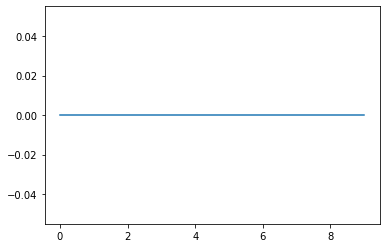

In [12]:
plt.plot(diff[0,0,:])

In [13]:
print("p(0): ", p[0])
print("q(0): ", q[0])
print("p(1): ", p[1])
print("q(1): ", q[1])
print("r(1): ", r[1])

p(0):  [[1.09834921 0.79711516]
 [0.79711516 0.81208025]]
q(0):  [0.02459987 0.19893452]
p(1):  [[0.43546004 0.15111019]
 [0.15111019 0.08103248]]
q(1):  [0.77863271 0.36967441]
r(1):  -0.42019109058864723


## Adaptive Graal to solve VI

In [6]:
def adaptive_graal(J, F, prox_g, x1, numb_iter=100, phi=1.5, output=False): 
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(Fx - F(x0))
    rho = 1. / phi + 1. / phi**2
    values = [J(x)]
    diff = [0]
    time_list = [perf_counter() - begin]
    th = 1

    for i in range(numb_iter):
        x1 = prox_g(x_ - la * Fx)
        Fx1 = F(x1)
        if output:
            for j in range(dimY):
                if hx[j+1](x1[:dimX], j+1) > 0:
                    print("UNFEASIBLE")
                    print("hx: ", hx[j+1](x1[:dimX], j+1))
                    continue
            print("iteration: ", i, "\n")
            print("F: ", Fx1, "\n")
            print("x: ", x1[:dimX], "\n")
            print("y: ", x1[dimX:dimX+dimY], "\n")
            print("u: ", x1[dimX+dimY:dimX+dimY+dimU], "\n")
            #print("prox: ", prox_g(x_ - la * Fx, la), "\n")

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(Fx1 - Fx)**2
        n1_div_n2 = n1/n2 if n2 != 0 else la*10

        la1 = min(rho * la, 0.25 * phi * th / la * n1_div_n2)
        #values.append(np.linalg.norm(x_-x1)/la)
        x_ = ((phi - 1) * x1 + x_) / phi
        #if output:
            #print (i, la)
        th = phi * la1 / la
        x, la, Fx = x1, la1, Fx1
        #if i%50 == 0: 
            #print("x at iteration ", i , ": ", x)
        temp = values[-1]
        values.append(J(x))
        diff.append(np.absolute(temp - values[-1]))
        time_list.append(perf_counter() - begin)
    end = perf_counter()
    
    for j in range(dimY):
        if hx[j+1](x1[:dimX], j+1) > 0:
            print("UNFEASIBLE")
            print("hx: ", hx[j+1](x1[:dimX], j+1))
    print("CPU time for aGRAAL:", end - begin)
    return values, x, x_, time_list, diff

## Solver of VI

In [7]:
prox_g = prob.prox
# starting point
N = 10000
#q0 = np.ones(dimX + dimY+ dimU)
#print(q0.shape)
#for i in range(dimY):
#    if hx[i+1](q_re, i+1) > 0:
#        print("UNFEASIBLE")
print(q0)

[0.10090951 0.89159057 0.56809279 ... 0.52024878 0.77255877 1.        ]


In [8]:
showout= False
ans1 = adaptive_graal(J_co, F_co, prox_g, q0, numb_iter=N, phi=1.5, output=showout)

CPU time for aGRAAL: 74.2956191


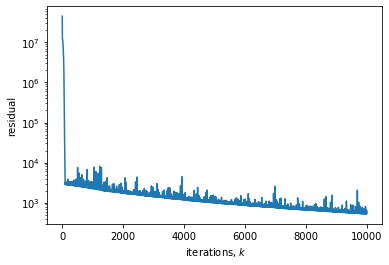

In [9]:
plt.plot(ans1[0])

plt.yscale('log')

plt.xlabel(u' iterations, $k$')
plt.ylabel(u'residual')

#plt.savefig('figures/nash.pdf', bbox_inches='tight')
plt.show()
if showout:
    print("Answer is", ans1[0][-1])
    print("X is", ans1[2])
    print("fx is", fx(ans1[2][0:dimX]))
    #print("diff is",ans1[4])

In [108]:
print("J is", ans1[0][-1])
X = np.concatenate((ans1[2][:dimX], np.zeros(10)))
#print(X.shape)
Z = ans1[2]
X = ans1[2][:dimX]
Y = ans1[2][dimX:]
print("FX :", Y[0]*gradh[1](X,1))
print("j :", LA.norm(Z-prox_g((Z-F_co(Z)))))
k = 1
print("h ", hx[k](X, k))
print("y: ", ans1[2][dimX:])
print("fx is", fx(ans1[2][0:dimX]))

J is 0.9000655098916494
FX : [4.4e-323 4.4e-323 4.4e-323 5.4e-323 5.9e-323 1.5e-323 4.9e-323 3.5e-323
 4.4e-323 4.0e-323 7.9e-323 7.4e-323 2.5e-323 3.5e-323 5.4e-323 4.9e-323
 5.4e-323 2.0e-323 5.4e-323 4.9e-323 4.4e-323 3.0e-323 4.4e-323 3.5e-323
 6.9e-323 5.4e-323 5.9e-323 6.4e-323 7.4e-323 7.4e-323 4.4e-323 7.4e-323
 4.9e-323 4.4e-323 5.4e-323 3.0e-323 3.0e-323 3.5e-323 5.9e-323 3.0e-323
 5.4e-323 5.9e-323 5.4e-323 5.4e-323 3.5e-323 5.4e-323 5.9e-323 3.5e-323
 3.5e-323 3.5e-323 7.9e-323 4.4e-323 4.4e-323 5.9e-323 5.9e-323 4.9e-323
 2.5e-323 4.4e-323 7.4e-323 5.9e-323 2.5e-323 5.4e-323 4.9e-323 7.9e-323
 3.5e-323 4.4e-323 5.4e-323 6.4e-323 5.4e-323 4.9e-323 4.0e-323 3.5e-323
 4.4e-323 8.4e-323 7.4e-323 4.9e-323 4.4e-323 4.4e-323 4.4e-323 4.4e-323
 3.0e-323 3.0e-323 4.0e-323 6.9e-323 4.9e-323 4.0e-323 3.0e-323 5.9e-323
 3.0e-323 6.9e-323 6.9e-323 7.4e-323 5.9e-323 3.5e-323 5.9e-323 4.9e-323
 5.4e-323 3.0e-323 5.4e-323 6.4e-323]
j : 0.8988428895011699
h  -28826.63616817135
y:  [5.e-324

(F(x)-F(y))@(x-y) >=  for any X,Y 

## Solving the QCQP

In [ ]:
from scipy.optimize import minimize
cons = []
print(hx)
for i in range(len(hx)):
    temp = ({'type': 'ineq', 'fun': lambda x,i: hx[i](x,i) })
    cons.append(temp)
x = np.ones(dimX)
vec = A@x
for i in range(A.shape[0]):
    temp = ({'type': 'eq', 'fun': lambda x,i: vec[i] })
    cons.append(temp)
bnds = []
for i in range(dimX):
    temp = ((0, None))
    bnds.append(temp)
res = minimize(fx, x, method='SLSQP', bounds=bnds, constraints=cons)

In [ ]:
print(fx(res['x']))
print(res['x'])
#print("Answer is:", res)

RESTCODE

*---------------------------------------------------------------------------*

RESTCODE

In [ ]:
p, q, r, A, b = randQCQPmat(dimX,dimY,True,True, dimU)

In [ ]:

#start_time = time.time()
#fx, hx, gradf, gradh = toQCQPmat(p, q, r)
#print("--- %s seconds ---" % (time.time() - start_time))
hxs = []
gradhs = []
for i in range(len(hx)):
    temp = lambda x: -1*hx[i](x)
    hxs.append(temp)
    temp = lambda x: -1*gradh[i](x)
    gradhs.append(temp)